# Derive sparse grids in frequency for surrogate amplitude and phase

MP 12/2017

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as spline

import lal

import sys
sys.path.insert(0, '../../src')
import taylorf2 as f2

Define a grid on which TaylorF2 should be evaluated for frequencies below the surrogate starting frequency.

One possibility is to choose points to minimize the spline error as in http://iopscience.iop.org/article/10.1088/0264-9381/31/19/195010/pdf, Sec 5.1. There, the following functions for the gridspacing as a function of frequency are derived for the TaylorF2 amplitude and phasing:

$$
\Delta_A(f) \propto f^{31/24}\\
\Delta_\phi(f) \propto f^{17/12}
$$

We can use algorithm 1 with these gridspacings to calculate grids. We tweak the prefactors to give desirable levels of errors in amplitude and phase by checking evaluation on a fine grid.

In [2]:
def Delta_A(Mf):
    return 1.0*Mf**(31.0/24.0) # paper used 0.1

def Delta_phi(Mf):
    return 1.0*Mf**(17.0/12.0) # paper used 0.3

def CSE_points(Mf_min, Mf_max, delta_Mf_fun):
    g = [Mf_min]
    while g[-1] < Mf_max:
        P = g[-1] + delta_Mf_fun(g[-1])
        if P < Mf_max:
            g.append(P)
        else:
            g.append(Mf_max)
    return np.array(g)

The idea for this method is guided by the form of the spline interpolation error. The error of a
cubic spline interpolant $I_4[g](x)$ of a function $g(x) \in C^4[a,b]$ with derivatives given at the
endpoints on a set of nodes $x_i$ with the largest gridspacing $\Delta := \max_i [x_{i+1} - x_i]$ is

$$
\lVert g - I_4[g] \rVert_\infty \leq \frac{5}{384} \Delta^4 \lVert g^{(4)} \rVert_\infty
$$



To generate a sparse frequency grid we demand that the gridspacing as a function of frequency is chosen such that the local spline interpolation error (i.e. we apply equation (5.4)
for every subset of four grid points) stays constant over the desired frequency range. Going
back to equation (5.4) we see that the gridspacing as a function of frequency has to be
proportional to the reciprocal of the fourth root of the fourth derivative of the function to be
approximated so that the error stays constant (if the equality were to hold).

Assume a simplified amplitude $A \propto f^{-7/6}$

For the phase we look at the dominant terms in the phase evolution of the TaylorF2 approximant for an equal-mass non-spinning binary: $\phi_\mathrm{F2} = -\frac{\pi}{4} + 0.2(Mf)^{-1} + 0.014 (Mf)^{-5/3} + \mathcal{O}((Mf)^{-2/3})$

See the Mathematica notebook `Sparse Grid Spline Errors.nb` for the calculation of the expressions for $\Delta f$.

We find
$$
\Delta_A^\text{L}(f) = \frac{6 f^{19/12}}{\sqrt{91}}\\
\Delta_\phi^\text{L}(f) = 4.00892 f^{11/6}-12.8858 f^{11/6} f^{2/3} + \mathcal{O}\left(f^{4/3}\right)
$$


In [3]:
def Delta_A_linear(Mf):
    return 1.0*Mf**(19.0/12.0)

def Delta_phi_linear(Mf):
    return 1.0*4.00892*Mf**(11.0/6.0) - 12.8858*Mf**(11.0/6.0)*Mf**(2.0/3.0)

## Low frequency grids (cubic splines) [not used anymore]

In [ ]:
Mtot_sec = 2.0 * lal.MTSUN_SI # lowest total mass we consider is 2 Msun
Mf_min, Mf_max = 1.0 * Mtot_sec, 2048.0 * Mtot_sec
# lowest frequency in current surrogate is Mf=0.00021
Mf_max = min(0.00021, Mf_max)

# Errors are larger at boundaries, so let's add a safety factor to surpress this
Mf_min_orig = Mf_min
Mf_max_orig = Mf_max
Mf_min = 0.9*Mf_min
Mf_max = 1.1*Mf_max
print 'Mf_min, Mf_max:', Mf_min, Mf_max

Mf_amp = CSE_points(Mf_min, Mf_max, Delta_A)
Mf_phi = CSE_points(Mf_min, Mf_max, Delta_phi)
print 'Number of points:', len(Mf_amp), len(Mf_phi)

In [ ]:
np.save("Mf_amp_TF2_cubic.npy", Mf_amp)
np.save("Mf_phi_TF2_cubic.npy", Mf_phi)

In [ ]:
# Example parameters
eta = 0.222
spin1z, spin2z = 0.32, -0.098
lambda1, lambda2 = 2833.0, 3476.0
tbymc, phic = 0.0, 0.0

In [ ]:
# Grid for testing interpolation accuracy
g_test = np.linspace(Mf_min, Mf_max, 50000)
print min(np.diff(Mf_amp)), min(np.diff(Mf_phi)), np.diff(g_test)[0]

Amplitude

In [ ]:
amp = f2.taylorf2_amp_1pn(Mf_amp, eta)
ampI = spline(Mf_amp, amp, k=3, ext=0)

amp_test = f2.taylorf2_amp_1pn(g_test, eta)
amp_err_abs = ampI(g_test) - amp_test
amp_err_rel = amp_err_abs / amp_test

In [ ]:
plt.loglog(g_test, np.abs(amp_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(amp_err_rel), '.', label='rel');
plt.legend(loc=3)
#plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

Phase

In [ ]:
phi = f2.taylorf2_phase(Mf_phi, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phiI = spline(Mf_phi, phi, k=3, ext=0)

phi_test = f2.taylorf2_phase(g_test, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phi_err_abs = phiI(g_test) - phi_test
phi_err_rel = phi_err_abs / phi_test

In [ ]:
plt.loglog(g_test, np.abs(phi_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(phi_err_rel), '.', label='rel');
plt.legend(loc=3)
# plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

## Sparse frequency grids for entire range (cubic)

The 20 point grid used in the surrogate is not sufficient to represent TaylorF2 at low frequency in the surrogate frequency range $Mf \in [0.00021, 0.07]$. 

To solve this problem, we use sparse grids covering the entire frequency range from ET-like starting frequencies to the BNS merger frequency and a bit beyond.

In [4]:
Mtot_sec = 2.0 * lal.MTSUN_SI # lowest total mass we consider is 2 Msun
Mf_min = 1.0 * Mtot_sec # 1Hz starting frequency
Mf_max = 0.07 # upper frequency cutoff used in surrogate of corrections

# Errors are larger at boundaries, so let's add a safety factor to surpress this
Mf_min_orig = Mf_min
Mf_max_orig = Mf_max
Mf_min = 0.9*Mf_min
Mf_max = 1.1*Mf_max
print 'Mf_min, Mf_max:', Mf_min, Mf_max

Mf_amp = CSE_points(Mf_min, Mf_max, Delta_A)
Mf_phi = CSE_points(Mf_min, Mf_max, Delta_phi)
print 'Number of points:', len(Mf_amp), len(Mf_phi)

Mf_min, Mf_max: 8.86588384598e-06 0.077
Number of points: 102 307


In [7]:
np.save("Mf_amp_TF2_cubic.npy", Mf_amp)
np.save("Mf_phi_TF2_cubic.npy", Mf_phi)

In [8]:
# Example parameters
eta = 0.222
spin1z, spin2z = 0.32, -0.098
lambda1, lambda2 = 2833.0, 3476.0
tbymc, phic = 0.0, 0.0

In [9]:
# Grid for testing interpolation accuracy
g_test = np.linspace(Mf_min, Mf_max, 1000000)
print min(np.diff(Mf_amp)), min(np.diff(Mf_phi)), np.diff(g_test)[0]

2.97948336296e-07 6.95995159792e-08 7.69912111074e-08


Amplitude

In [14]:
amp = f2.taylorf2_amp_1pn(Mf_amp, eta)
ampI = spline(Mf_amp, amp, k=3, ext=0)

amp_test = f2.taylorf2_amp_1pn(g_test, eta)
amp_err_abs = ampI(g_test) - amp_test
amp_err_rel = amp_err_abs / amp_test

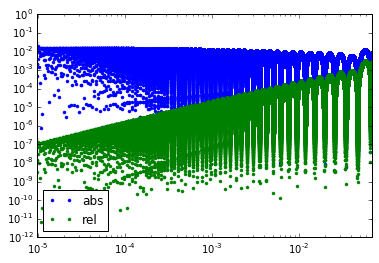

In [15]:
plt.loglog(g_test, np.abs(amp_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(amp_err_rel), '.', label='rel');
plt.legend(loc=3)
#plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

Phase

In [16]:
phi = f2.taylorf2_phase(Mf_phi, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phiI = spline(Mf_phi, phi, k=3, ext=0)

phi_test = f2.taylorf2_phase(g_test, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phi_err_abs = phiI(g_test) - phi_test
phi_err_rel = phi_err_abs / phi_test

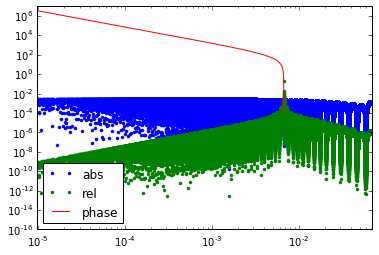

In [17]:
plt.loglog(g_test, np.abs(phi_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(phi_err_rel), '.', label='rel');
plt.loglog(g_test, -phi_test, label='phase')
plt.legend(loc=3)
# plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

## Sparse frequency grids for entire range (linear)

The 20 point grid used in the surrogate is not sufficient to represent TaylorF2 at low frequency in the surrogate frequency range $Mf \in [0.00021, 0.07]$. 

To solve this problem, we use sparse grids covering the entire frequency range from ET-like starting frequencies to the BNS merger frequency and a bit beyond.

In [44]:
Mtot_sec = 2.0 * lal.MTSUN_SI # lowest total mass we consider is 2 Msun
Mf_min = 1.0 * Mtot_sec # 1Hz starting frequency
Mf_max = 0.07 # upper frequency cutoff used in surrogate of corrections

# Errors are larger at boundaries, so let's add a safety factor to surpress this
Mf_min_orig = Mf_min
Mf_max_orig = Mf_max
Mf_min = 0.9*Mf_min
Mf_max = 1.1*Mf_max
print 'Mf_min, Mf_max:', Mf_min, Mf_max

Mf_amp = CSE_points(Mf_min, Mf_max, Delta_A_linear)
Mf_phi = CSE_points(Mf_min, Mf_max, Delta_phi_linear)
print 'Number of points:', len(Mf_amp), len(Mf_phi)

Mf_min, Mf_max: 8.86588384598e-06 0.077
Number of points: 1519 4892


The number of points is **much increased** compared to the cubic spline case. 
With a prefactor of 1 we get 15 times more points and the error level rises a bit to ~ 1e-1.

TODO: 
  * We'll have to find out whether the evaluation of the linear spline is more than 15 times faster for long waveforms.
  * The practical way is to just implement it in C using gsl.

In [55]:
1519 / 102., 4892 / 307.

(14.892156862745098, 15.93485342019544)

In [45]:
np.save("Mf_amp_TF2_linear.npy", Mf_amp)
np.save("Mf_phi_TF2_linear.npy", Mf_phi)

In [46]:
# Example parameters
eta = 0.222
spin1z, spin2z = 0.32, -0.098
lambda1, lambda2 = 2833.0, 3476.0
tbymc, phic = 0.0, 0.0

In [47]:
# Grid for testing interpolation accuracy
g_test = np.linspace(Mf_min, Mf_max, 1000000)
print min(np.diff(Mf_amp)), min(np.diff(Mf_phi)), np.diff(g_test)[0]

1.00129003091e-08 2.18735566023e-09 7.69912111074e-08


Amplitude

In [50]:
amp = f2.taylorf2_amp_1pn(Mf_amp, eta)
ampI = spline(Mf_amp, amp, k=1, ext=0)

amp_test = f2.taylorf2_amp_1pn(g_test, eta)
amp_err_abs = ampI(g_test) - amp_test
amp_err_rel = amp_err_abs / amp_test

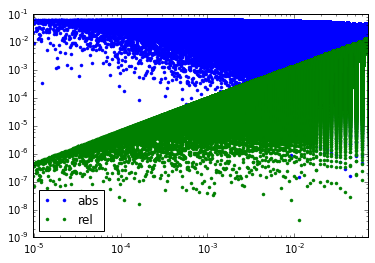

In [51]:
plt.loglog(g_test, np.abs(amp_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(amp_err_rel), '.', label='rel');
plt.legend(loc=3)
#plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);

Phase

In [52]:
phi = f2.taylorf2_phase(Mf_phi, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phiI = spline(Mf_phi, phi, k=1, ext=0)

phi_test = f2.taylorf2_phase(g_test, tbymc, phic, eta, spin1z, spin2z, lambda1, lambda2)
phi_err_abs = phiI(g_test) - phi_test
phi_err_rel = phi_err_abs / phi_test

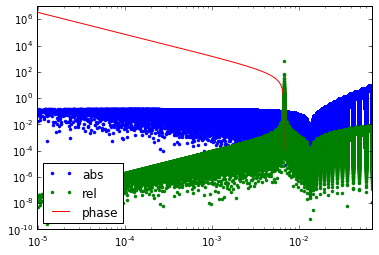

In [53]:
plt.loglog(g_test, np.abs(phi_err_abs), '.', label='abs');
plt.loglog(g_test, np.abs(phi_err_rel), '.', label='rel');
plt.loglog(g_test, -phi_test, label='phase')
plt.legend(loc=3)
# plt.xlim([Mf_min, Mf_max]);
plt.xlim([Mf_min_orig, Mf_max_orig]);